<a href="https://colab.research.google.com/github/ARU-Bioinformatics/advanced-programming-SBV/blob/main/circadian_rhythm_with_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating a circadian rhythm with NEURON

Leloup, J. C., Gonze, D., & Goldbeter, A. (1999). Limit cycle models for circadian rhythms based on transcriptional regulation in Drosophila and Neurospora. Journal of biological rhythms, 14(6), 433-448. https://doi.org/10.1177/074873099129000948

We'll use the initial conditions from the BioModels version: https://www.ebi.ac.uk/biomodels/BIOMD0000000298

## Scripting NEURON basics
To allow us to perform "experiments" in systems space it is useful to start with a system that is well defined from multiple laboratories. There are few good examples of this, but the best is NEURON. The objectives of this part of the tutorial are to get familiar with basic operations of NEURON using Python.

### What is NEURON?
The NEURON simulation environment is a powerful engine for performing simulations of neurons and biophysical neural networks. It permits the construction of biologically realistic membranes with active and passive ion channels, combined with virtual connectivity and electrophysiology tools to drive and measure neuron and network behaviors.




*If you are interesting in doing more with NEURON then you can learn how to simulate a cell here: https://neuron.yale.edu/neuron/docs/scripting-neuron-basics*

### Step 1: Import the neuron module into Python
Any code that is not part of Python's Built-in Functions must be imported. The Python interface to NEURON goes through the neuron module, especially the neuron.h submodule. The neuron module has additional submodules, including neuron.rxd for reaction-diffusion dynamics, neuron.gui2 for Jupyter-compatible PlotShape graphs, and neuron.gui for Interviews-based GUI tools. The neuron.h submodule also allows loading files, executing code, and calling functions written in HOC, an older scripting language supported by NEURON. This allows the continued use of HOC libraries in Python code.

In [ ]:
! pip3 install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load libraries
We'll want NEURON's h library and its standard run system. NEURON's crxd and rxd modules are generally interchangable, and while that is true here, for performance reasons, we strongly recommend using crxd here.

In [ ]:
from neuron import h, crxd as rxd
h.load_file('stdrun.hoc')

1.0

We'll also use matplotlib to plot concentrations of circadian proteins over time. We could of course use NEURON's graphics, bokeh, or any other plotting library.



In [ ]:
from matplotlib import pyplot as plt


### Units
NEURON measures concentrations in mM and time in ms. Leloup et al., 1999, however expresses concentration in nM and time in hours. We could ignore the unit inconsistency and NEURON would still be able to run the simulation, however if we did so, this could cause problems for interacting with other NEURON mechanisms. To avoid this problem, we define nM and hour in terms of NEURON's base units and include the units when specifying parameter values:

In [ ]:
# (In NEURON 7.7+, we could just do "from neuron.units import nM, hour")

mM = 1
msec = 1
nM = 1e-6 * mM
sec = 1e3 * msec
minute = 60 * sec
hour = 60 * minute

### Helper functions for clarity
For clarity, we prefer to define parameters and species by just specifying their names and values instead of repeteadly writing rxd.Parameter or rxd.Species. Fortunately, since Python uses keyword arguments and allows functions to modify the global variable dictionary, we can define helper functions that let us do exactly that:

In [ ]:
def declare_parameters(**kwargs):
    '''enables clean declaration of parameters in top namespace'''
    for key, value in kwargs.items():
        globals()[key] = rxd.Parameter(r, name=key, initial=value)


def declare_species(**kwargs):
    '''enables clean declaration of species in top namespace'''
    for key, value in kwargs.items():
        globals()[key] = rxd.Species(r, name=key, initial=value, atolscale=1e-3 * nM)

We notify NEURON's variable step solver that we want an absolute error tolerance on the order of 1e-3 nM since Leloup et al's concentrations are on the order of 1 nM.

You don't need to fully understand the code for these functions; their usage will be clear below, and they can be reused verbatim in many similar models.

Beginning in NEURON 7.7, it is possible to declare a Vector and set it to record from a variable in a single line; we duplicate this functionality for older versions of NEURON using the following:

In [ ]:
def recorder(ptr):
    '''return a vector that records the pointer'''
    vec = h.Vector()
    vec.record(ptr)
    return vec

### Define the morphology
Even though this simulation does not use any electrophysiology, we define the nrn_region to allow the option of easily connecting to electrophysiology kinetics in the future:

In [ ]:
cell = h.Section(name='cell')
cell.diam = cell.L = 5
r = rxd.Region([cell], nrn_region='i')

### Parameters
Using Parameters instead of numbers makes it easier to rerun simulations. Beginning in NEURON 7.7, the rxd parameters panel allows quickly changing parameter values and rerunning simulations from the graphical user interface.

Here we explicitly specify units (defined above) as the units in Leloup et al do not match NEURON's default units. We use the helper function defined above instead of repeatedly writing rxd.Parameter.

In [ ]:
declare_parameters(
    vsP=1.1 * nM / hour,
    vmP=1.0 * nM / hour,
    KmP=0.2 * nM,
    KIP=1.0 * nM,
    ksP=0.9 / hour,
    vdP=2.2 * nM / hour,
    KdP=0.2 * nM,
    vsT=1.0 * nM / hour,
    vmT=0.7 * nM / hour,
    KmT=0.2 * nM,
    KIT=1.0 * nM,
    ksT=0.9 / hour,
    vdT=3.0 * nM / hour,
    KdT=0.2 * nM,
    kdC=0.01 * nM / hour,
    kdN=0.01 * nM / hour,
    k1=0.8 / hour,
    k2=0.2 / hour,
    k3=1.2 / (nM * hour),
    k4=0.6 / hour,
    kd=0.01 * nM / hour,
    V1P=8.0 * nM / hour,
    V1T=8.0 * nM / hour,
    V2P=1.0 * nM / hour,
    V2T=1.0 * nM / hour,
    V3P=8.0 * nM / hour,
    V3T=8.0 * nM / hour,
    V4P=1.0 * nM / hour,
    V4T=1.0 * nM / hour,
    K1P=2.0 * nM,
    K1T=2.0 * nM,
    K2P=2.0 * nM,
    K2T=2.0 * nM,
    K3P=2.0 * nM,
    K3T=2.0 * nM,
    K4P=2.0 * nM,
    K4T=2.0 * nM,
    n=4
)

### Declaring proteins
As with the parameters, we declare all the protiens (species), their initial values, and units:

In [ ]:
declare_species(
    MP=0.0614368 * nM,
    P0=0.0169928 * nM,
    P1=0.0141356 * nM,
    P2=0.0614368 * nM,
    MT=0.0860342 * nM,
    T0=0.0217261 * nM,
    T1=0.0213384 * nM,
    T2=0.0145428 * nM,
    C=0.207614 * nM,
    CN=1.34728 * nM
)

### Reactions
For the explanation of the model, see Leloup et al., 1999 or Leloup and Goldbeter 1998. Here we define all the reactions for NEURON. For those reactions that are not governed by mass-action kinetics, we specify custom_dynamics=True.

In [ ]:
MTtranscription = rxd.Rate(MT, vsT * KIT ** n / (KIT ** n + CN ** n))
MPtranscription = rxd.Rate(MP, vsP * KIP ** n / (KIP ** n + CN ** n))
MTdegradation = rxd.Rate(MT, -(vmT * MT / (KmT + MT) + kd * MT))
MPdegradation = rxd.Rate(MP, -(vmP * MP / (KmP + MP) + kd * MP))
T0production = rxd.Rate(T0, ksT * MT)
T0degradation = rxd.Rate(T0, -kd * T0)
T1degradation = rxd.Rate(T1, -kd * T1)
T2degradation = rxd.Rate(T2, -kd * T2)
T2degradation_due_to_light = rxd.Rate(T2, -vdT * T2 / (KdT + T2))
T0toT1 = rxd.Reaction(T0, T1, V1T * T0 / (K1T + T0), V2T * T1 / (K2T + T1), custom_dynamics=True)
T1toT2 = rxd.Reaction(T1, T2, V3T * T1 / (K3T + T1), V4T * T2 / (K4T + T2), custom_dynamics=True)
P0production = rxd.Rate(P0, ksP * MP)
P0degradation = rxd.Rate(P0, -kd * P0)
P1degradation = rxd.Rate(P1, -kd * P1)
P2degradation = rxd.Rate(P2, -kd * P2 - vdP * P2 / (KdP + P2))
P0toP1 = rxd.Reaction(P0, P1, V1P * P0 / (K1P + P0), V2P * P1 / (K2P + P1), custom_dynamics=True)
P1toP2 = rxd.Reaction(P1, P2, V3P * P1 / (K3P + P1), V4P * P2 / (K4P + P2), custom_dynamics=True)
P2T2toC = rxd.Reaction(P2 + T2, C, 0 + k3, 0 + k4)  # the 0+ works around a bug prior to NEURON 7.7
CtoCN = rxd.Reaction(C, CN, 0 + k1, 0 + k2)  # the 0+ works around a bug prior to NEURON 7.7
Cdegradation = rxd.Rate(C, -kdC * C)
CNdegradation = rxd.Rate(CN, -kdN * CN)

### Record states
We define a number of Vectors to record variables of interest. For convenience we use the recorder function defined above:

First, and always, we'll record time. Otherwise we won't know how to interpret the remaining variables:

In [ ]:
t = recorder(h._ref_t)


Now the concentrations:

In [ ]:
mpvec = recorder(MP.nodes[0]._ref_concentration)
cnvec = recorder(CN.nodes[0]._ref_concentration)
p0vec = recorder(P0.nodes[0]._ref_concentration)
p1vec = recorder(P1.nodes[0]._ref_concentration)
p2vec = recorder(P2.nodes[0]._ref_concentration)
cvec = recorder(C.nodes[0]._ref_concentration)

### Run the simulation
Since we're running for hours rather than ms, we'll use the variable step solver.

In [ ]:
h.finitialize(-65)
h.CVode().active(True)
h.continuerun(72 * hour)

0.0

### Plot
We begin by converting the units back from NEURON's units to nM and hours to have more intuitive values to display. We also define the variable pt which is the total concentration of PER protein, in any of its forms:

In [ ]:
pt = (p0vec.as_numpy() + p1vec + p2vec + cvec + cnvec) / nM
mp = mpvec.as_numpy() / nM
cn = cnvec.as_numpy() / nM
t_in_hours = t.as_numpy() / hour

Finally the actual plot, which you can compare to Figure 2A of Leloup et al., 1999.

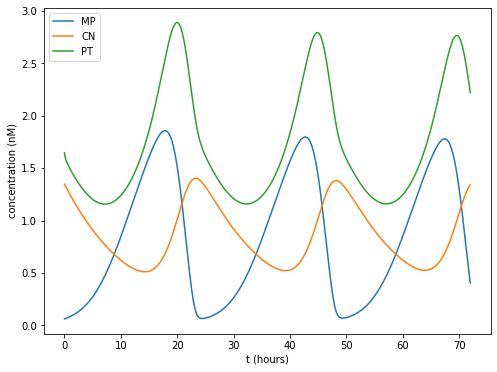

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(t_in_hours, mp, label='MP')
plt.plot(t_in_hours, cn, label='CN')
plt.plot(t_in_hours, pt, label='PT')
plt.legend()
plt.xlabel('t (hours)')
plt.ylabel('concentration (nM)')
plt.show()

Well done, you have plotted a circadian rhythm from the model! Try changing the intial pararemters and explore how tat effects your resulting rhythms.